In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split as tts
import torch
from torch import nn,optim
from torchinfo import summary
from torchmetrics.classification import BinaryAccuracy
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score

from tqdm.auto import tqdm
from pathlib import Path
import random
from typing import Dict,List
import warnings
warnings.filterwarnings("ignore")

In [4]:
images_path = Path(r"D:\brain_mri_scan_images")
total_classes = os.listdir(images_path)

# Remove '.DS_Store' from the images_path
if '.DS_Store' in total_classes:
    total_classes.remove('.DS_Store')

# Remove '.DS_Store' from the total_classes list
total_classes = [cls for cls in total_classes if cls != '.DS_Store']

In [5]:
total_classes

['negative', 'positive']

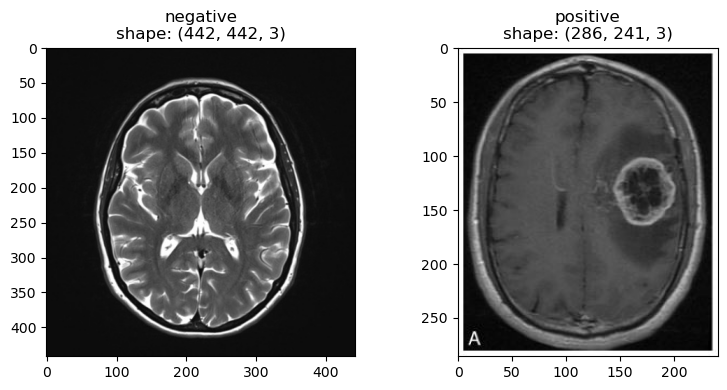

In [6]:
images_path_list = list(images_path.glob("*/*.jpg"))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax = ax.flat

for i, c in enumerate(total_classes):
    img_path_class = Path(os.path.join(images_path, c))
    img_path_list = list(img_path_class.glob("*.jpg"))

    if not img_path_list:
        print(f"No images found for class {c}")
        continue

    img_selected = random.choice(img_path_list)
    img_BGR = cv2.imread(str(img_selected))
    img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
    ax[i].imshow(img_RGB)
    ax[i].set_title(f"{img_selected.parent.stem}\nshape: {img_RGB.shape}")

fig.tight_layout()
plt.show()

In [8]:
#getting the count of images in each classes

total_images_negative = len(os.listdir(r"D:\brain_mri_scan_images\negative"))
total_images_positive = len(os.listdir(r"D:\brain_mri_scan_images\positive"))


print(f'negative = {total_images_negative} images')
print(f'positive = {total_images_positive} images')

negative = 98 images
positive = 129 images


In [9]:
#preprocessing the data

image_path_and_class = {"image_path":[], 
                      "target":[]}

for img_path in images_path_list:
    image_path_and_class["image_path"].append(img_path)
    image_path_and_class["target"].append(img_path.parent.stem)
    
df_image_path_and_class = pd.DataFrame(image_path_and_class)
df_image_path_and_class.head()

,image_path,target
0,D:\brain_mri_scan_images\negative\0.jpg,negative
1,D:\brain_mri_scan_images\negative\1.jpg,negative
2,D:\brain_mri_scan_images\negative\10.jpg,negative
3,D:\brain_mri_scan_images\negative\11.jpg,negative
4,D:\brain_mri_scan_images\negative\12.jpg,negative


In [10]:
X = df_image_path_and_class.drop("target", axis = 1)
y = df_image_path_and_class["target"]

In [13]:
X_train, X_test, y_train, y_test = tts(X,y, test_size = 0.2, random_state = 124, stratify = y)

In [14]:
#applying mapping to target variable to binarize

label_map = {'positive':1, 
             'negative':0}

y_train_array = np.array(y_train.map(label_map), dtype = float).reshape(-1,1)
y_train_torch = torch.from_numpy(y_train_array)

y_test_array = np.array(y_test.map(label_map), dtype = float).reshape(-1,1)
y_test_torch = torch.from_numpy(y_test_array)

In [15]:
#adding transformations to the train and test set

train_transforms = transforms.Compose([
    transforms.Resize((128,128)), 
    transforms.TrivialAugmentWide(), 
    transforms.ToTensor()])

test_transforms = transforms.Compose([
    transforms.Resize((128,128)), 
    transforms.ToTensor()])

In [16]:
#we apply the transformations to our images through an iteration to our data sets
#train
total_images_train = len(X_train)
images_train = [None]*total_images_train
for i,(_,img_path_train) in enumerate(X_train.iterrows()):
    img_train = Image.open(Path(img_path_train[0])).convert("RGB")
    images_train[i] = train_transforms(img_train)
    

#test set.
total_images_test = len(X_test)
images_test = [None]*total_images_test

for i,(_,img_path_test) in enumerate(X_test.iterrows()):
    img_test = Image.open(Path(img_path_test[0])).convert("RGB")
    images_test[i] = test_transforms(img_test)

In [17]:
#Stacking
X_train_torch = torch.stack(images_train)
X_test_torch = torch.stack(images_test)

In [18]:
# creating a Dataset class to create our Datasets.
class CustomDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        x = self.data[idx]
        y = self.target[idx]
        
        return x,y

In [19]:
train_dataset = CustomDataset(X_train_torch, y_train_torch)
test_dataset = CustomDataset(X_test_torch, y_test_torch)

In [20]:
BATCH_SIZE = 7
NUM_WORKERS = 0

train_dataloader = DataLoader(train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS)

test_dataloader = DataLoader(test_dataset, 
                             batch_size = BATCH_SIZE, 
                             shuffle = False, 
                             num_workers = NUM_WORKERS)

In [21]:
#checking a batch
batch_images, batch_labels = next(iter(train_dataloader))

batch_images.shape, batch_labels.shape

(torch.Size([7, 3, 128, 128]), torch.Size([7, 1]))

In [22]:
#defining the model

model_efficientnet = efficientnet_b2()

In [23]:
device = 'cpu'
device

'cpu'

In [24]:
summary(model = model_efficientnet, 
        input_size = [7,3,128,128], 
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 17, 
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape       Output Shape      Param #           Trainable
EfficientNet (EfficientNet)                                  [7, 3, 128, 128]  [7, 1000]         --                True
├─Sequential (features)                                      [7, 3, 128, 128]  [7, 1408, 4, 4]   --                True
│    └─Conv2dNormActivation (0)                              [7, 3, 128, 128]  [7, 32, 64, 64]   --                True
│    │    └─Conv2d (0)                                       [7, 3, 128, 128]  [7, 32, 64, 64]   864               True
│    │    └─BatchNorm2d (1)                                  [7, 32, 64, 64]   [7, 32, 64, 64]   64                True
│    │    └─SiLU (2)                                         [7, 32, 64, 64]   [7, 32, 64, 64]   --                --
│    └─Sequential (1)                                        [7, 32, 64, 64]   [7, 16, 64, 64]   --                True
│    │    └─MBConv (0)               

In [25]:
#checking the last layer to modify it

model_efficientnet.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [26]:
output_shape = 1

model_efficientnet.classifier = nn.Sequential(#nn.Dropout(p = 0.3, inplace = True), 
                                              nn.Linear(in_features = 1408, 
                                                        out_features = output_shape, 
                                                        bias = True))

In [27]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_efficientnet.parameters(), lr = 0.01)

In [28]:
def train_step(model:torch.nn.Module, 
               dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module, 
               optimizer:torch.optim.Optimizer):
    
    model.train()
    
    train_loss = 0.
    accuracy_train = BinaryAccuracy(threshold = 0.5).to(device)
    
    for batch,(X,y) in enumerate(dataloader):
        X, y = X.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)
        
        y_pred_logits = model(X)
        
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred_probs = torch.sigmoid(y_pred_logits)
        accuracy_train.update(y_pred_probs, y)
        
    train_accuracy = accuracy_train.compute()
    train_loss = train_loss/len(dataloader)
    
    return train_loss, train_accuracy

In [29]:
def test_step(model:torch.nn.Module, 
              dataloader:torch.utils.data.DataLoader, 
              loss_fn:torch.nn.Module):
    
    model.eval()
    
    test_loss = 0.
    accuracy_test = BinaryAccuracy(threshold = 0.5).to(device)
    
    with torch.inference_mode():
        
        for batch,(X,y) in enumerate(dataloader):
            X, y = X.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)
            
            y_pred_logits = model(X)
            loss = loss_fn(y_pred_logits, y)
            test_loss += loss.item()
            
            
            y_pred_probs = torch.sigmoid(y_pred_logits)
            accuracy_test.update(y_pred_probs, y)
            
    test_accuracy = accuracy_test.compute()
    test_loss = test_loss/len(dataloader)
    
    return test_loss, test_accuracy

In [30]:
# We define our checkpoint to save the best model.
def save_checkpoint(filename, model, epoch, loss, optimizer):
    state = {"filename":filename, 
             "state_dict":model.state_dict(), 
             "epoch":epoch, 
             "loss":loss, 
             "optimizer":optimizer.state_dict()}
    torch.save(state, filename)

In [31]:
def train(model:torch.nn.Module, 
          train_dataloader:torch.utils.data.DataLoader, 
          test_dataloader:torch.utils.data.DataLoader, 
          loss_fn:torch.nn.Module, 
          optimizer:torch.optim.Optimizer, 
          epochs:int=10):
    
    results = {"train_loss":[], 
               "test_loss":[], 
               "train_accuracy":[], 
               "test_accuracy":[]}
    
    best_test_loss = float('inf')
    
    for epoch in tqdm(range(epochs)):
        
        train_loss, train_accuracy = train_step(model = model, 
                                                dataloader = train_dataloader, 
                                                loss_fn = loss_fn, 
                                                optimizer = optimizer)
        
        test_loss, test_accuracy = test_step(model = model, 
                                             dataloader = test_dataloader, 
                                             loss_fn = loss_fn)
        
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            file_name = "best_model.pt"
            save_checkpoint(file_name, model, epoch, best_test_loss, optimizer)
            
        print(f"Epoch: {epoch+1} | ", 
              f"Train Loss: {train_loss:.4f} | ", 
              f"Train Accuracy: {train_accuracy:.4f} | ", 
              f"Test Loss: {test_loss:.4f} | ", 
              f"Test Accuracy: {test_accuracy:.4f}")
            
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)
        results["train_accuracy"].append(train_accuracy)
        results["test_accuracy"].append(test_accuracy)
    
    return results

In [32]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [33]:
# We execute the training.
EPOCHS = 100
MODEL_RESULTS = train(model_efficientnet.to(device), 
                      train_dataloader, 
                      test_dataloader, 
                      loss_fn, 
                      optimizer, 
                      EPOCHS)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 1.1335 |  Train Accuracy: 0.4751 |  Test Loss: 0.7160 |  Test Accuracy: 0.5652
Epoch: 2 |  Train Loss: 0.9408 |  Train Accuracy: 0.5580 |  Test Loss: 118.3473 |  Test Accuracy: 0.5435
Epoch: 3 |  Train Loss: 0.8695 |  Train Accuracy: 0.4917 |  Test Loss: 2.1909 |  Test Accuracy: 0.5217
Epoch: 4 |  Train Loss: 0.7348 |  Train Accuracy: 0.5249 |  Test Loss: 1.1199 |  Test Accuracy: 0.4783
Epoch: 5 |  Train Loss: 0.7302 |  Train Accuracy: 0.5304 |  Test Loss: 1.9178 |  Test Accuracy: 0.6087
Epoch: 6 |  Train Loss: 0.7178 |  Train Accuracy: 0.4696 |  Test Loss: 0.6930 |  Test Accuracy: 0.5652
Epoch: 7 |  Train Loss: 0.7380 |  Train Accuracy: 0.5470 |  Test Loss: 0.7012 |  Test Accuracy: 0.5652
Epoch: 8 |  Train Loss: 0.6977 |  Train Accuracy: 0.5525 |  Test Loss: 2.3791 |  Test Accuracy: 0.6087
Epoch: 9 |  Train Loss: 0.6851 |  Train Accuracy: 0.5359 |  Test Loss: 0.6638 |  Test Accuracy: 0.5652
Epoch: 10 |  Train Loss: 0.7007 |  Train Accuracy: 0.5359 |  Test Loss:

In [34]:
# Function to plot the loss and metric during each training epoch.
def plot_loss_metric_curve(model_results:Dict[str,List[float]]):
    
    train_loss = model_results["train_loss"]
    test_loss = model_results["test_loss"]
    
    train_accuracy = [float(value) for value in model_results["train_accuracy"]]
    test_accuracy = [float(value) for value in model_results["test_accuracy"]]
    
    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
    plt.style.use("ggplot")
    axes = axes.flat
    
    axes[0].plot(train_loss, color = "red", label = "Train")
    axes[0].plot(test_loss, color = "blue", label = "Test")
    axes[0].set_title("CrossEntropyLoss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].legend()
    
    axes[1].plot(train_accuracy, color = "red", label = "Train")
    axes[1].plot(test_accuracy, color = "blue", label = "Test")
    axes[1].set_title("Metric of performance: Accuracy", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].set_ylabel("Score", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].legend()
    
    fig.tight_layout()
    fig.show()

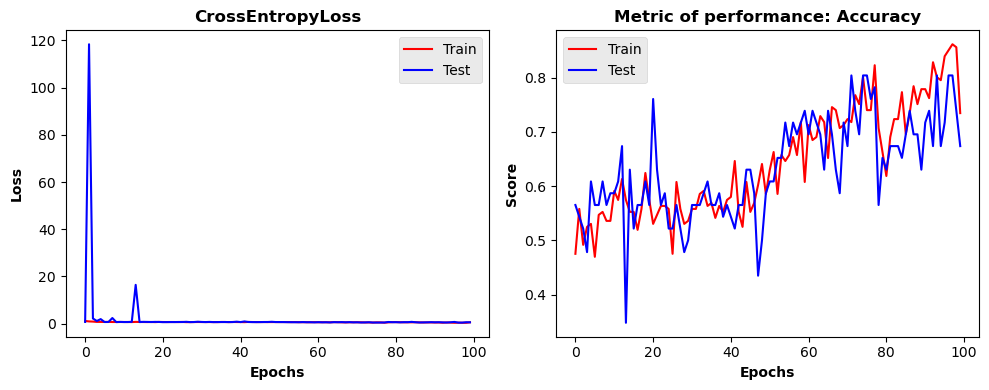

In [35]:
plot_loss_metric_curve(MODEL_RESULTS)

In [36]:
# We load the best model.
path_checkpoint = "best_model.pt"
checkpoint = torch.load(path_checkpoint)

In [37]:
# We visualize the time when we obtained the least loss.
epoch = checkpoint["epoch"] + 1
loss = checkpoint["loss"]
print(f"Epoch: {epoch}")
print(f"Loss: {loss}")

Epoch: 97
Loss: 0.4367871486714908


In [38]:
model_efficientnet.load_state_dict(checkpoint["state_dict"])

model_efficientnet.eval()

with torch.inference_mode():
  y_pred_train_logits = model_efficientnet(X_train_torch.to(device))
  y_pred_test_logits = model_efficientnet(X_test_torch.to(device))

In [39]:
# Predictions Training
y_pred_train_probs = torch.sigmoid(y_pred_train_logits)
y_pred_train_class = torch.round(y_pred_train_probs).squeeze(dim = 1)
y_pred_train = y_pred_train_class.cpu().numpy()

# Predictions Test
y_pred_test_probs = torch.sigmoid(y_pred_test_logits)
y_pred_test_class = torch.round(y_pred_test_probs).squeeze(dim = 1)
y_pred_test = y_pred_test_class.cpu().numpy()

In [40]:
y_train_np = y_train_array.astype(int).squeeze()
y_pred_train_np = y_pred_train.astype(int)

y_test_np = y_test_array.astype(int).squeeze()
y_pred_test_np = y_pred_test.astype(int)

cf_mx_train = confusion_matrix(y_train_np, y_pred_train_np)
cf_mx_test = confusion_matrix(y_test_np, y_pred_test_np)

In [41]:
#Confusion matrix
confusion_matrix_train = cf_mx_train.tolist()
confusion_matrix_test = cf_mx_test.tolist()

# Print the confusion matrices
print("Confusion Matrix Train:")
for row in confusion_matrix_train:
    print(row)

print("\nConfusion Matrix Test:")
for row in confusion_matrix_test:
    print(row)

Confusion Matrix Train:
[66, 12]
[3, 100]

Confusion Matrix Test:
[15, 5]
[4, 22]


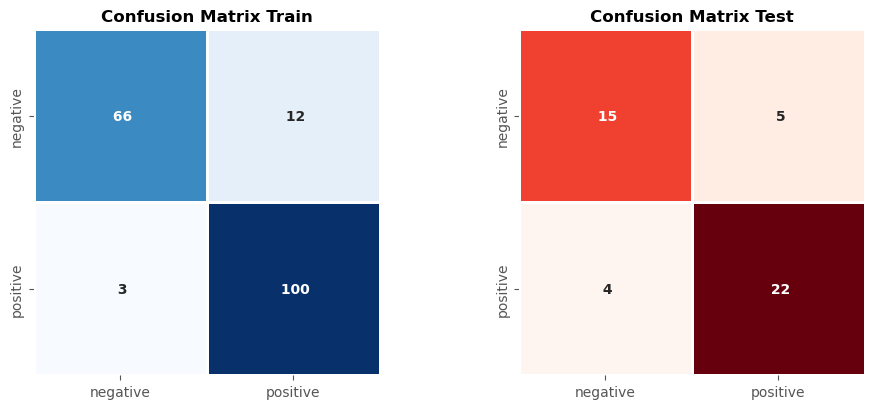

In [42]:
# Let's see this matrix in heatmap
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4.2))
ax = ax.flat
sns.heatmap(cf_mx_train, 
            cmap = 'Blues', 
            annot = True, 
            fmt = ' ', 
            annot_kws = {"fontsize":10, 
                         "fontweight":"bold"}, 
            linewidths = 1, 
            linecolor = "white", 
            cbar = False, 
            square = True, 
            xticklabels = ["negative","positive"],
            yticklabels = ["negative","positive"],
            ax = ax[0])
ax[0].set_title('Confusion Matrix Train', fontsize = 12, fontweight = 'bold', color = 'black')

sns.heatmap(cf_mx_test, 
            cmap = 'Reds', 
            annot = True, 
            fmt = ' ', 
            annot_kws = {"fontsize":10, 
                         "fontweight":"bold"}, 
            linewidths = 1, 
            linecolor = "white", 
            cbar = False, 
            square = True, 
            xticklabels = ["negative","positive"], 
            yticklabels = ["negative","positive"],
            ax = ax[1])
ax[1].set_title('Confusion Matrix Test', fontsize = 12, fontweight = 'bold', color = 'black')

fig.tight_layout()
fig.show()

In [43]:
# We create a dictionary to do a reverse mapping to the labels for both the training and test set.
id2label = {0: 'negative', 1: 'positive'}

In [44]:
# We convert the original labels and predictions from number to string by applying a mapping.
y_pred_train_id2label = np.array(pd.Series(y_pred_train_np).map(id2label))

y_train_np = np.array(y_train)

y_pred_test_id2label = np.array(pd.Series(y_pred_test_np).map(id2label))

y_test_np = np.array(y_test)

In [45]:
print("=="*30)
print(" " * 13, "Classification Report Train")
print("=="*30)
print(classification_report(y_train_np, y_pred_train_id2label))

print("=="*30)
print(" " * 13, "Classification Report Test")
print("=="*30)
print(classification_report(y_test_np, y_pred_test_id2label))

              Classification Report Train
              precision    recall  f1-score   support

    negative       0.96      0.85      0.90        78
    positive       0.89      0.97      0.93       103

    accuracy                           0.92       181
   macro avg       0.92      0.91      0.91       181
weighted avg       0.92      0.92      0.92       181

              Classification Report Test
              precision    recall  f1-score   support

    negative       0.79      0.75      0.77        20
    positive       0.81      0.85      0.83        26

    accuracy                           0.80        46
   macro avg       0.80      0.80      0.80        46
weighted avg       0.80      0.80      0.80        46

